In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input as efficientnet_preprocess
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [5]:
def load_all_batches(source_folder, num_batches):
    all_images = []
    all_labels = []
    for i in range(num_batches):
        image_path = os.path.join(source_folder, f'images_batch_{i}.npy')
        label_path = os.path.join(source_folder, f'labels_batch_{i}.npy')
        if not os.path.exists(image_path) or not os.path.exists(label_path):
            print(f"Batch {i} not found, skipping.")
            continue
        images = np.load(image_path)
        labels = np.load(label_path)
        all_images.append(images)
        all_labels.append(labels)
    X = np.concatenate(all_images, axis=0)
    y = np.concatenate(all_labels, axis=0)
    return X, y

# Set source folder (the folder where your batch files are stored)
source_folder = '/Users/issackondreddy/Desktop/Programming/ML Project/Lung Cancer Detection/data/processed'
num_batches = 181  # Adjust to the actual number of batches you have

X_images, y = load_all_batches(source_folder, num_batches)
print("Loaded filtered images shape:", X_images.shape)
print("Loaded labels shape:", y.shape)

Loaded filtered images shape: (2888, 224, 224, 3)
Loaded labels shape: (2888,)


In [6]:
target_size = (224, 224)

def preprocess_images(images, target_size=(224, 224)):
    processed = []
    for img in images:
        # If image is grayscale (2D) or has a single channel, convert it to 3 channels.
        if img.ndim == 2:
            img = np.stack([img] * 3, axis=-1)
        elif img.shape[-1] == 1:
            img = np.concatenate([img] * 3, axis=-1)
        # Resize image using tf.image.resize
        img_resized = tf.image.resize(img, target_size).numpy()
        processed.append(img_resized)
    processed = np.array(processed)
    processed = processed.astype(np.float32) / 255.0
    processed = efficientnet_preprocess(processed)
    return processed

X_images_processed = preprocess_images(X_images, target_size=target_size)
print("Preprocessed images shape:", X_images_processed.shape)

Preprocessed images shape: (2888, 224, 224, 3)


In [7]:
# Set paths to the preselected features and labels (from your ResNet pipeline)
features_file = '/Users/issackondreddy/Desktop/Programming/ML Project/Lung Cancer Detection/data/features_selected_Resnet/selected_features.npy'
labels_file = '/Users/issackondreddy/Desktop/Programming/ML Project/Lung Cancer Detection/data/features_selected_Resnet/labels.npy'

X_resnet_features = np.load(features_file)
# Assuming these labels match the ones from the images (or you can use y from Cell 2 if identical)
y_features = np.load(labels_file)

print("Preselected ResNet features shape:", X_resnet_features.shape)
print("Labels from features shape:", y_features.shape)

Preselected ResNet features shape: (2888, 100)
Labels from features shape: (2888,)


In [8]:
# We assume the sample order is the same for both inputs.
X_img_train, X_img_val, X_feat_train, X_feat_val, y_train, y_val = train_test_split(
    X_images_processed, X_resnet_features, y, test_size=0.2, random_state=42)

print("Training image set:", X_img_train.shape)
print("Training selected features set:", X_feat_train.shape)
print("Training labels:", y_train.shape)
print("Validation image set:", X_img_val.shape)
print("Validation selected features set:", X_feat_val.shape)
print("Validation labels:", y_val.shape)

Training image set: (2310, 224, 224, 3)
Training selected features set: (2310, 100)
Training labels: (2310,)
Validation image set: (578, 224, 224, 3)
Validation selected features set: (578, 100)
Validation labels: (578,)


In [11]:
num_classes = len(np.unique(y))
print("Number of classes:", num_classes)

# Image branch (EfficientNetB0)
image_input = Input(shape=(224, 224, 3), name='image_input')
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=image_input)
base_model.trainable = False  # Freeze the EfficientNet base
x = GlobalAveragePooling2D()(base_model.output)

# Feature branch (Preselected ResNet features)
selected_feature_input = Input(shape=(X_resnet_features.shape[1],), name='selected_feature_input')
y_branch = Dense(64, activation='relu')(selected_feature_input)
y_branch = Dense(32, activation='relu')(y_branch)

# Concatenate both branches
combined = Concatenate()([x, y_branch])
z = Dense(256, activation='relu')(combined)
z = Dense(128, activation='relu')(combined)
z = Dense(64, activation='relu')(combined)
z = Dense(32, activation='relu')(z)
z = Dense(16, activation='relu')(z)
output = Dense(num_classes, activation='softmax')(z)

# Build the model
model = Model(inputs=[image_input, selected_feature_input], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Number of classes: 3
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 224, 224, 3)          0         ['image_input[0][0]']         
                                                                                                  
 normalization_2 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 224, 224, 3)          0         ['n

In [12]:
history = model.fit(
    {'image_input': X_img_train, 'selected_feature_input': X_feat_train},
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(
        {'image_input': X_img_val, 'selected_feature_input': X_feat_val},
        y_val
    )
)


Epoch 1/20
73/73 [==============================] - 40s 514ms/step - loss: 1.0868 - accuracy: 0.3827 - val_loss: 1.0551 - val_accuracy: 0.4498
Epoch 2/20
73/73 [==============================] - 34s 468ms/step - loss: 1.0337 - accuracy: 0.4368 - val_loss: 1.0571 - val_accuracy: 0.3997
Epoch 3/20
73/73 [==============================] - 32s 441ms/step - loss: 0.9555 - accuracy: 0.5251 - val_loss: 0.9649 - val_accuracy: 0.4931
Epoch 4/20
73/73 [==============================] - 34s 470ms/step - loss: 0.8968 - accuracy: 0.5541 - val_loss: 0.8422 - val_accuracy: 0.5484
Epoch 5/20
73/73 [==============================] - 34s 462ms/step - loss: 0.8559 - accuracy: 0.5701 - val_loss: 0.8238 - val_accuracy: 0.6176
Epoch 6/20
73/73 [==============================] - 33s 459ms/step - loss: 0.8274 - accuracy: 0.5887 - val_loss: 0.7839 - val_accuracy: 0.6107
Epoch 7/20
73/73 [==============================] - 46s 633ms/step - loss: 0.8108 - accuracy: 0.5944 - val_loss: 0.7911 - val_accuracy: 0.6107

19/19 [==============================] - 6s 321ms/step - loss: 0.6406 - accuracy: 0.6990
Validation Loss: 0.6405729651451111
Validation Accuracy: 0.6989619135856628


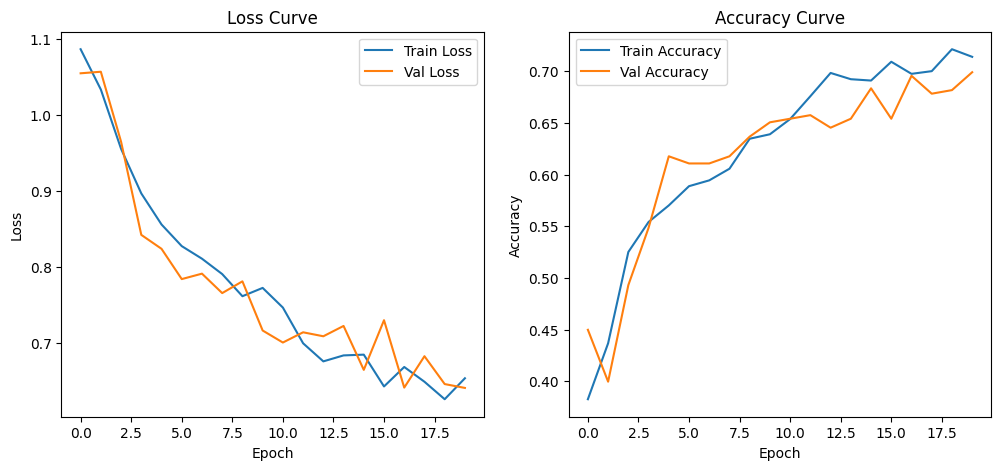

In [13]:
val_loss, val_accuracy = model.evaluate(
    {'image_input': X_img_val, 'selected_feature_input': X_feat_val},
    y_val
)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.show()